## **Notebook #6**
## Simple Recurrent Neural Network, Linear Predictor, MLP, ESN and LSTM for multi-step time series prediction.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Arthur Felipe dos Santos Fernandes


In [1]:
# Loading all the relevant libraries
from pandas import read_csv
from pandas import DataFrame
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

## **A base [unemployment rate] foi baixada no [link](https://fred.stlouisfed.org/series/UNRATE).**

In [2]:
# Structuring the dataset from a single time series, scaling and spliting into training / testing
def get_train_test(dataset, split_percent, time_steps, horizon):
    df = read_csv(dataset, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    # There is a kind of data leakage in the next command
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    df = DataFrame()
    for i in range(0,time_steps):
      df['t-' + str(time_steps-i-1)] = [data[j] for j in range(i, (len(data)-horizon-time_steps+i+1))]
    for i in range(1,horizon+1):
      df['t+' + str(i)] = [data[j] for j in range(time_steps+i-1, (len(data)-horizon+i))]
    print(df)
    df1 = df.copy()
    for i in range(1,horizon+1):
      df1 = df1.drop(['t+' + str(i)], axis = 1)
    dataX = np.array(df1)
    df2 = df['t+1']
    for i in range(2,horizon+1):
      df2 = pd.concat([df2, df['t+' + str(i)]], axis=1)
    datay = np.array(df2)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    X = dataX[range(split),:]
    y = datay[range(split)]
    Xt = dataX[split:,:]
    yt = datay[split:]
    return X, y, Xt, yt

time_steps = 11
horizon = 3
# Here you will decide which dataset to consider.
X, y, Xt, yt = get_train_test('unemployment_rate.csv', 0.8, time_steps, horizon)
# X, y, Xt, yt = get_train_test('monthly_sunspot.csv', 0.8, time_steps, horizon)

         t-10       t-9       t-8       t-7       t-6       t-5       t-4  \
0    0.073770  0.106557  0.122951  0.114754  0.081967  0.090164  0.090164   
1    0.106557  0.122951  0.114754  0.081967  0.090164  0.090164  0.114754   
2    0.122951  0.114754  0.081967  0.090164  0.090164  0.114754  0.106557   
3    0.114754  0.081967  0.090164  0.090164  0.114754  0.106557  0.098361   
4    0.081967  0.090164  0.090164  0.114754  0.106557  0.098361  0.106557   
..        ...       ...       ...       ...       ...       ...       ...   
873  0.360656  0.344262  0.344262  0.319672  0.303279  0.286885  0.286885   
874  0.344262  0.344262  0.319672  0.303279  0.286885  0.286885  0.270492   
875  0.344262  0.319672  0.303279  0.286885  0.286885  0.270492  0.278689   
876  0.319672  0.303279  0.286885  0.286885  0.270492  0.278689  0.237705   
877  0.303279  0.286885  0.286885  0.270492  0.278689  0.237705  0.221311   

          t-3       t-2       t-1       t-0       t+1       t+2       t+3  

##**Implementing the simple recurrent neural network**

In [3]:
# Execute this cell or the cell associated with one of the other predictors. They are mutually exclusive.
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, activation=activation[0], input_shape=input_shape))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model = create_RNN(hidden_units=30, dense_units=horizon, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
train_predict = model.fit(X, y, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
712/712 - 2s - loss: 0.0070 - 2s/epoch - 3ms/step
Epoch 2/20
712/712 - 1s - loss: 0.0015 - 898ms/epoch - 1ms/step
Epoch 3/20
712/712 - 1s - loss: 0.0012 - 927ms/epoch - 1ms/step
Epoch 4/20
712/712 - 1s - loss: 9.8357e-04 - 1s/epoch - 1ms/step
Epoch 5/20
712/712 - 1s - loss: 8.4942e-04 - 921ms/epoch - 1ms/step
Epoch 6/20
712/712 - 1s - loss: 8.2038e-04 - 891ms/epoch - 1ms/step
Epoch 7/20
712/712 - 1s - loss: 7.5703e-04 - 849ms/epoch - 1ms/step
Epoch 8/20
712/712 - 1s - loss: 7.2827e-04 - 879ms/epoch - 1ms/step
Epoch 9/20
712/712 - 1s - loss: 7.6685e-04 - 896ms/epoch - 1ms/step
Epoch 10/20
712/712 - 1s - loss: 7.0083e-04 - 865ms/epoch - 1ms/step
Epoch 11/20
712/712 - 1s - loss: 6.9995e-04 - 878ms/epoch - 1ms/step
Epoch 12/20
712/712 - 1s - loss: 6.8987e-04 - 878ms/epoch - 1ms/step
Epoch 13/20
712/712 - 1s - loss: 6.7645e-04 - 890ms/epoch - 1ms/step
Epoch 14/20
712/712 - 1s - loss: 6.9899e-04 - 858ms/epoch - 1ms/step
Epoch 15/20
712/712 - 1s - loss: 6.9420e-04 - 872ms/epoch - 1

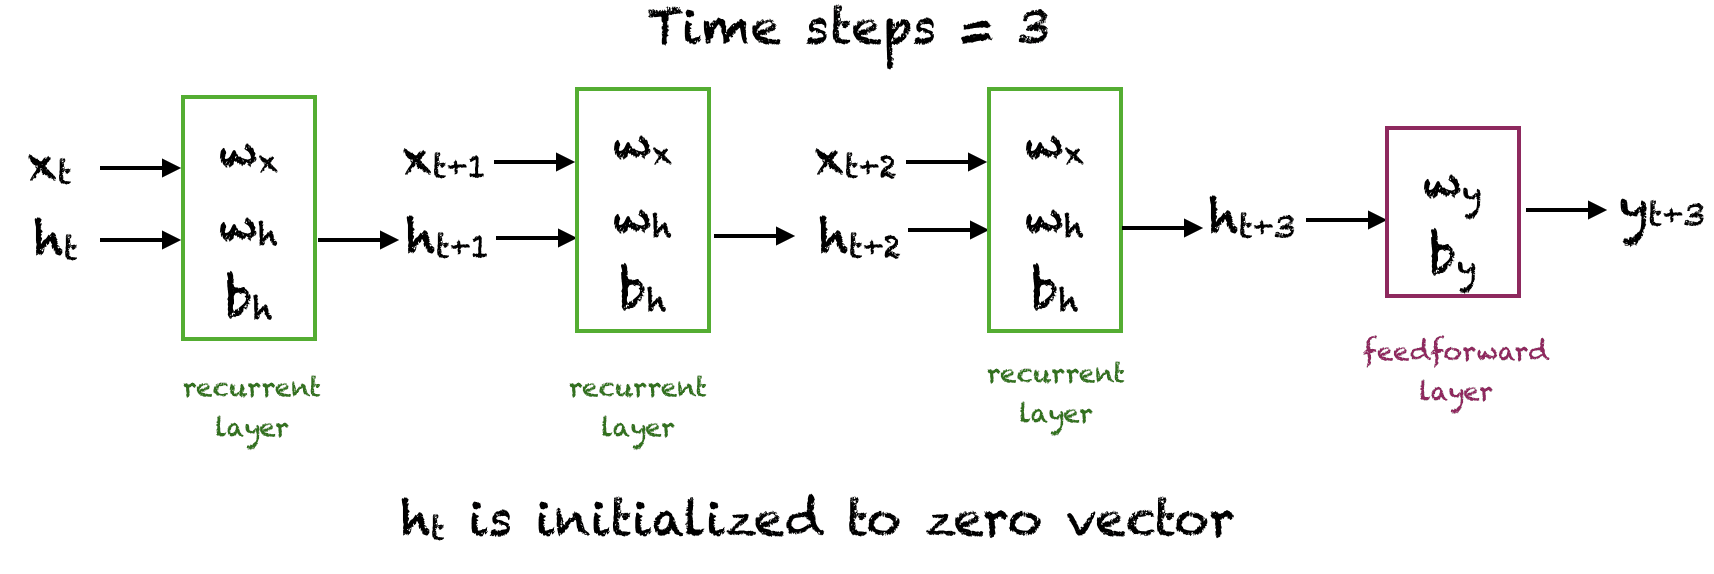

In [4]:
# Do not run this cell or upload the PNG file and then run.
# Configuration of the simple RNN
from IPython.display import Image
Image("RNN_info_flow.png", width = 600, height = 300)

In [5]:
def print_error(trainY, testY, train_predict, test_predict,i):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('t+%d RMSE train: %.3f RMSE' % (i+1, train_rmse))
    print('t+%d RMSE test: %.3f RMSE' % (i+1, test_rmse))

# Make predictions
train_predict = model.predict(X)
test_predict = model.predict(Xt)

for i in range(horizon):
  if(horizon == 1):
    y1_pred = train_predict
    y1_pred_t = test_predict
    y1 = y
    y1_t = yt
  elif(horizon > 1):
    y1_pred = train_predict[:,i]
    y1_pred_t = test_predict[:,i]
    y1 = y[:,i]
    y1_t = yt[:,i]
  print_error(y1, y1_t, y1_pred, y1_pred_t,i)

6/6 [==============================] - 0s 1ms/step
t+1 RMSE train: 0.019 RMSE
t+1 RMSE test: 0.071 RMSE
t+2 RMSE train: 0.028 RMSE
t+2 RMSE test: 0.099 RMSE
t+3 RMSE train: 0.037 RMSE
t+3 RMSE test: 0.119 RMSE


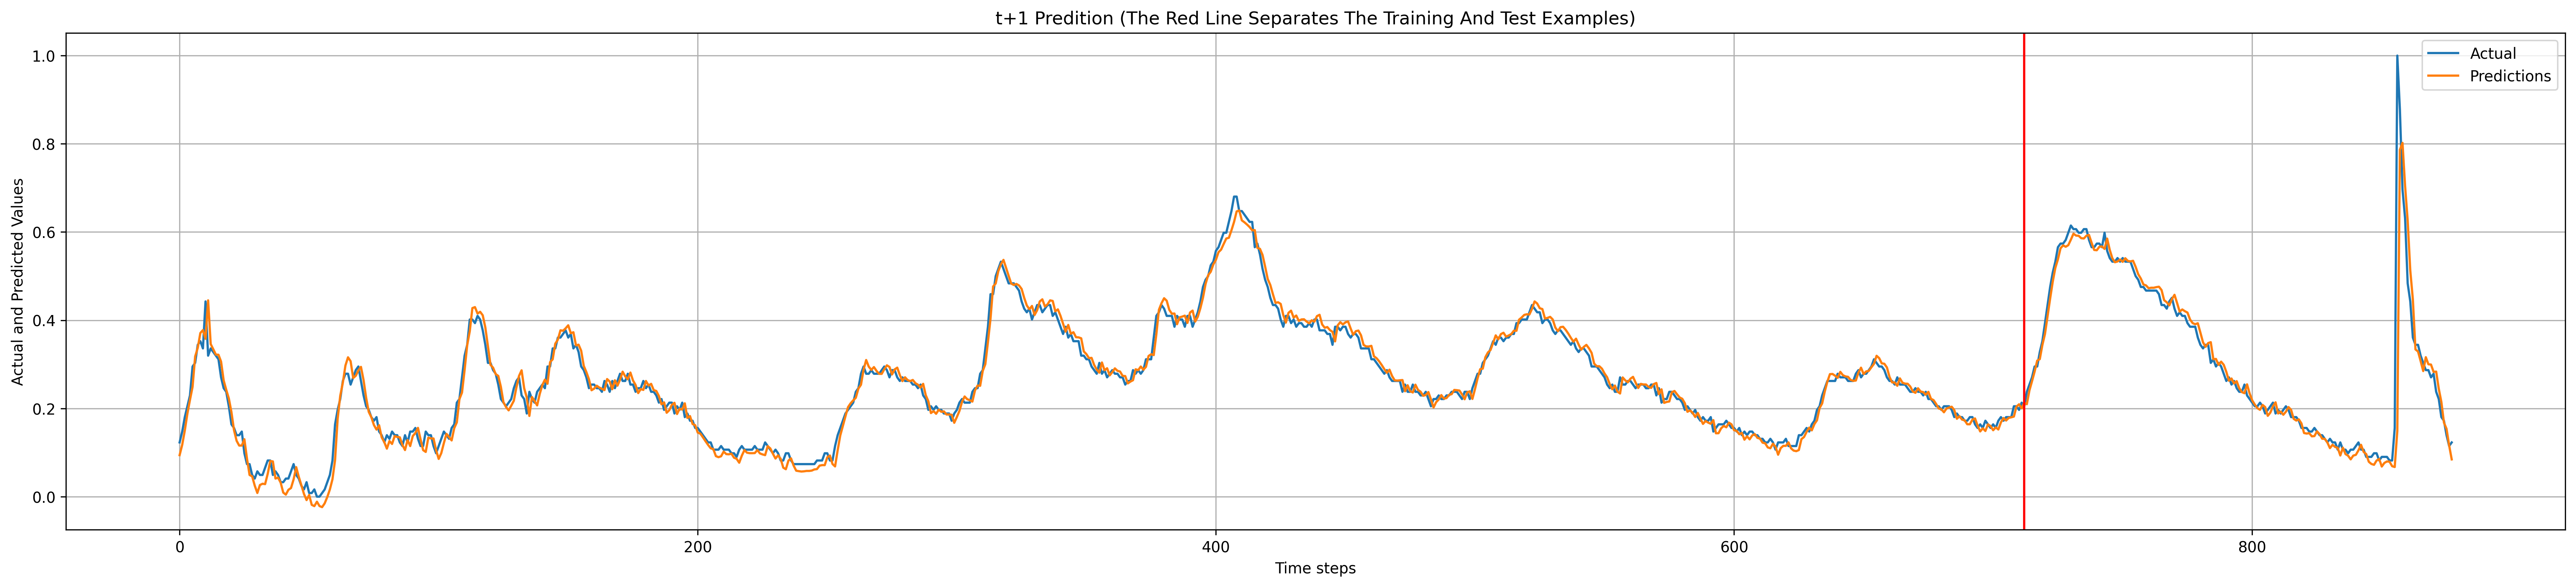

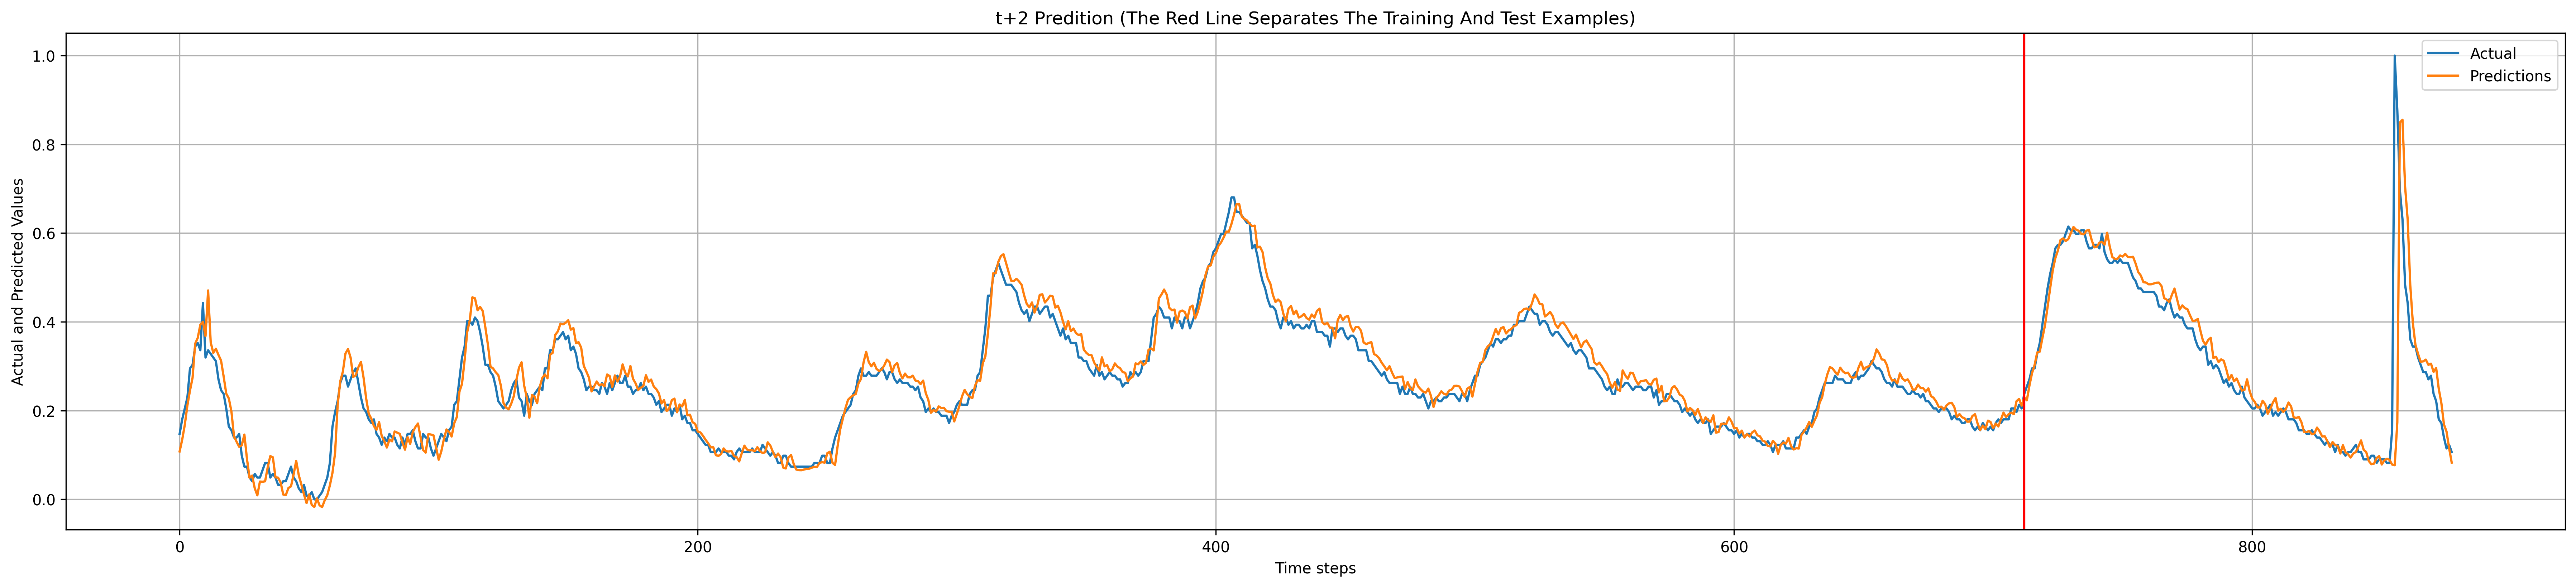

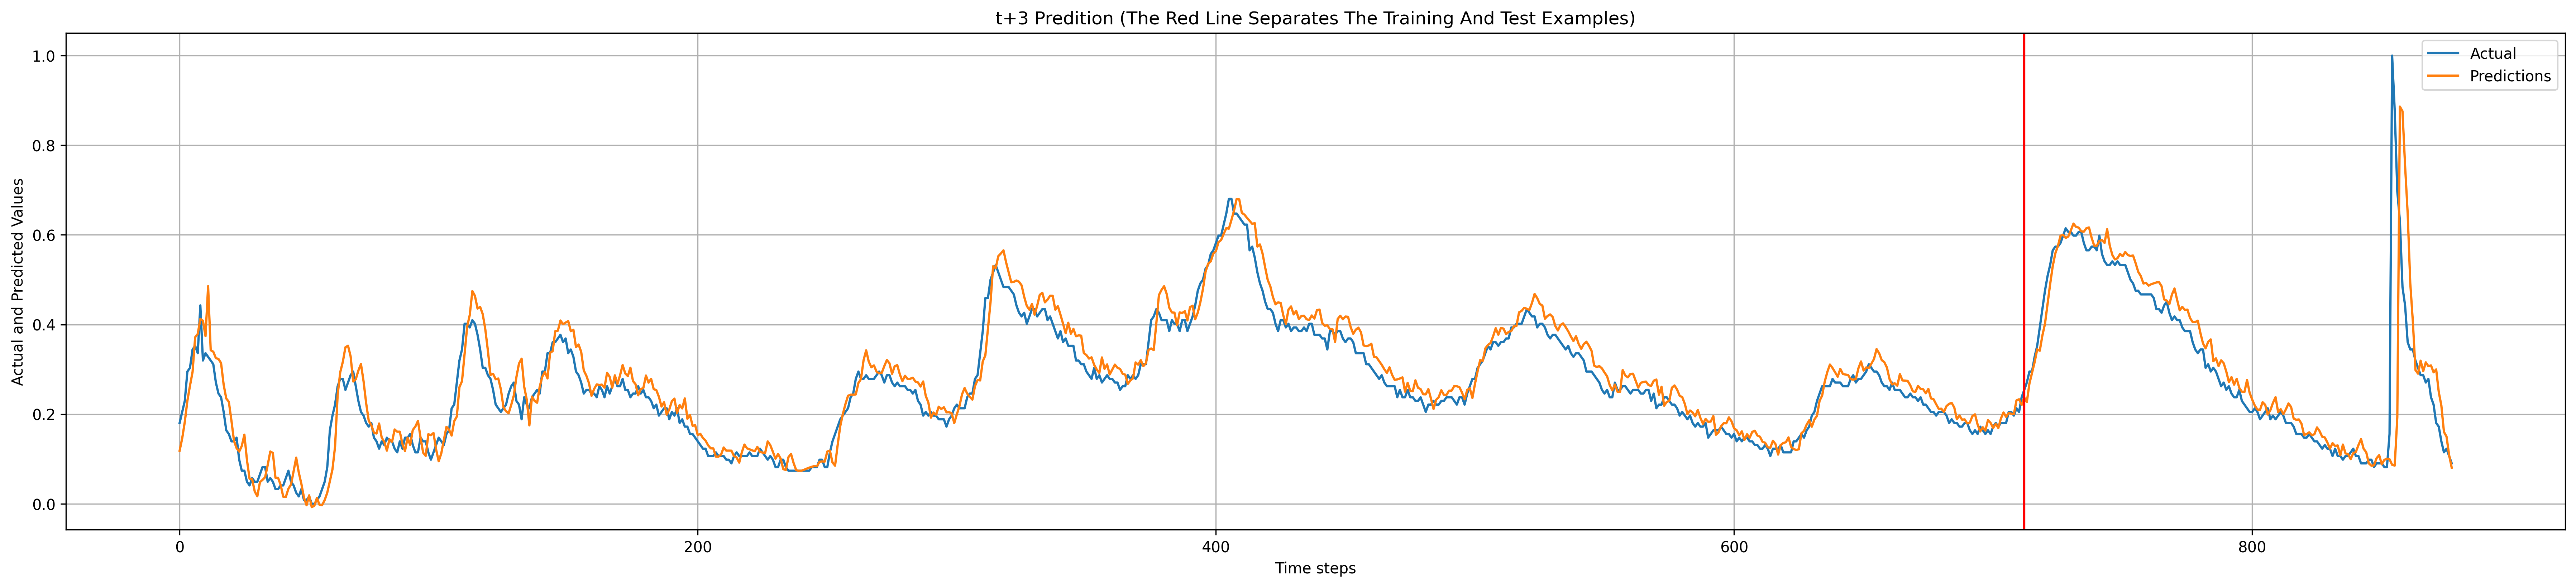

In [6]:
# Plot the predictions together with the actual values
def plot_result(trainY, testY, train_predict, test_predict,i):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(30, 6), dpi=300)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Time steps')
    plt.ylabel('Actual and Predicted Values')
    plt.title('t+%d Predition (The Red Line Separates The Training And Test Examples)' % (i+1))
    plt.grid(True)

for i in range(horizon):
  if(horizon == 1):
    y1_pred = train_predict
    y1_pred_t = test_predict
    y1 = y
    y1_t = yt
  elif(horizon > 1):
    y1_pred = train_predict[:,i]
    y1_pred_t = test_predict[:,i]
    y1 = y[:,i]
    y1_t = yt[:,i]
  plot_result(y1, y1_t, y1_pred, y1_pred_t,i)

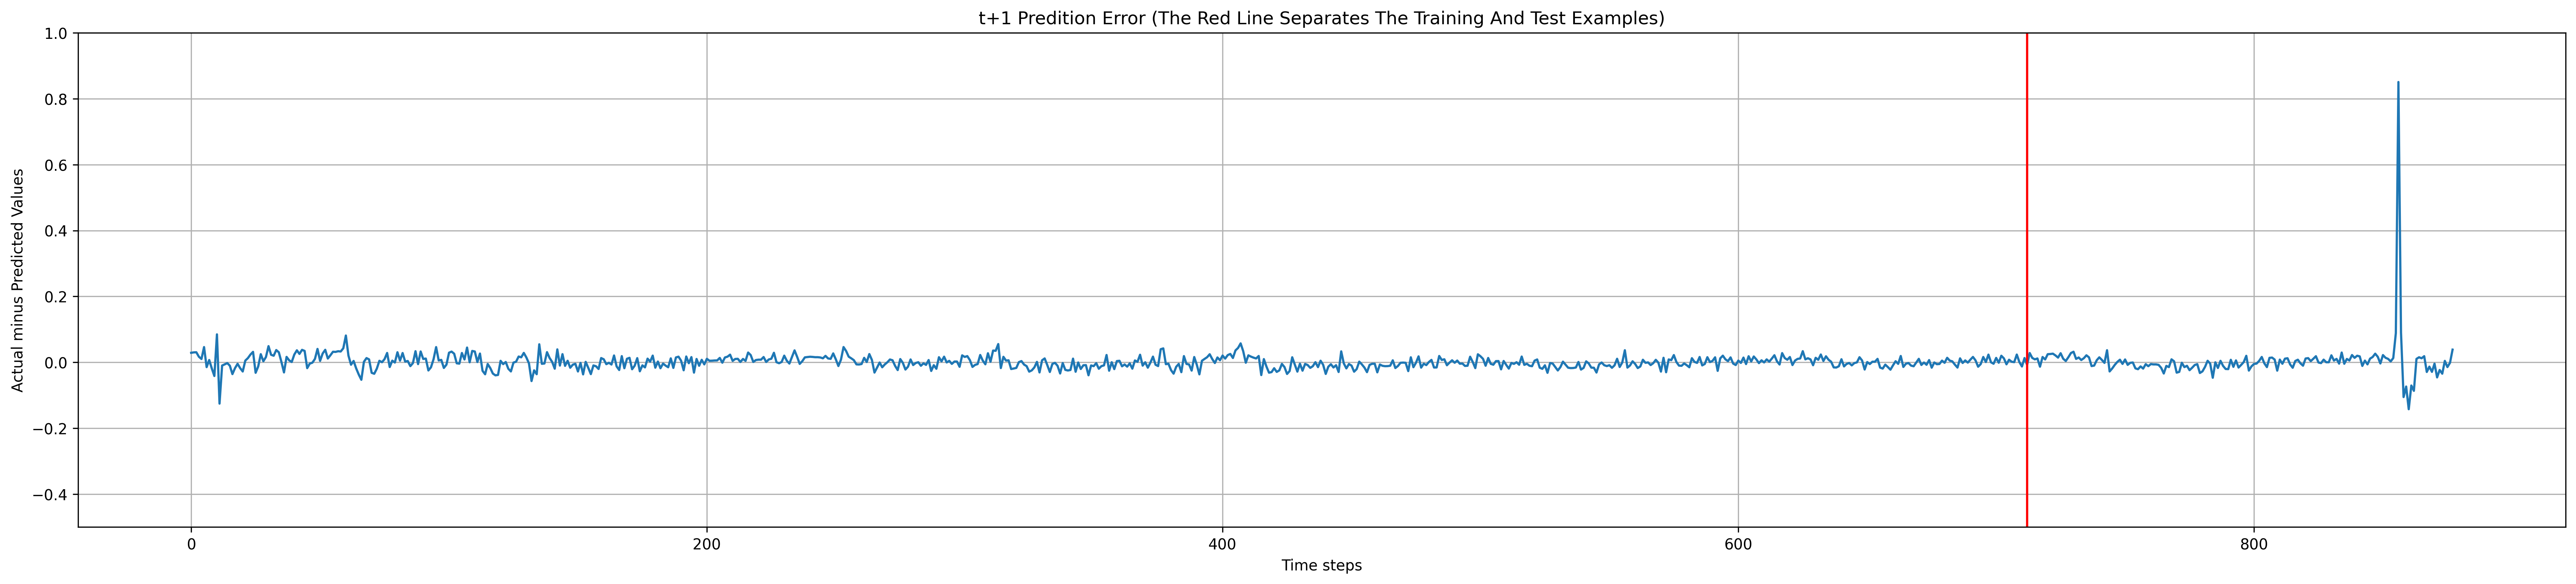

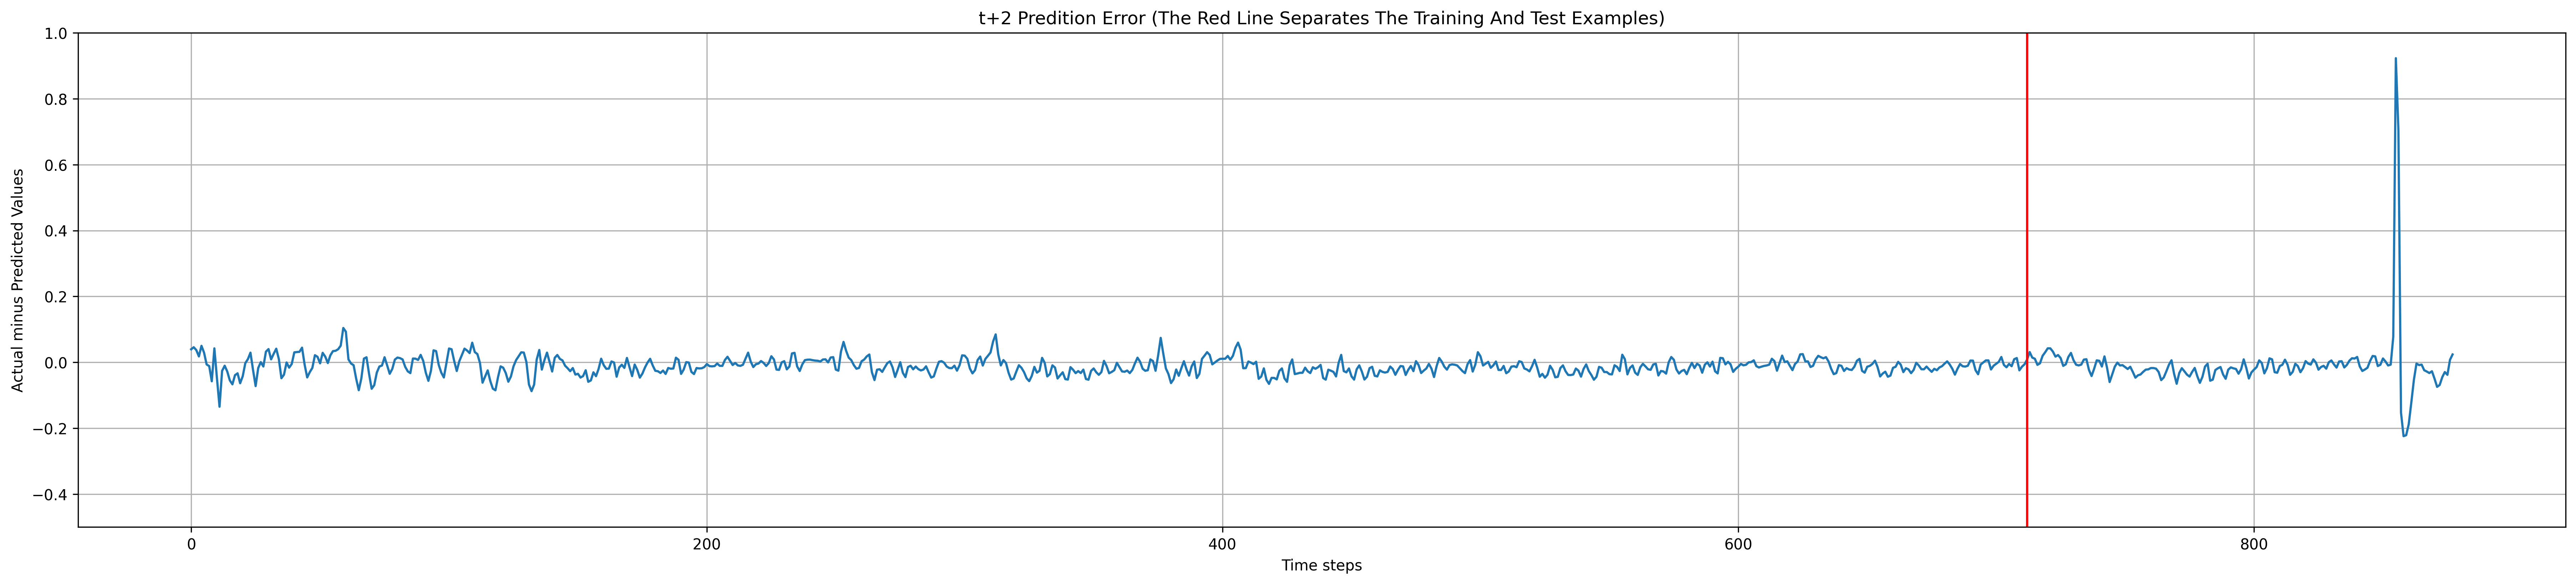

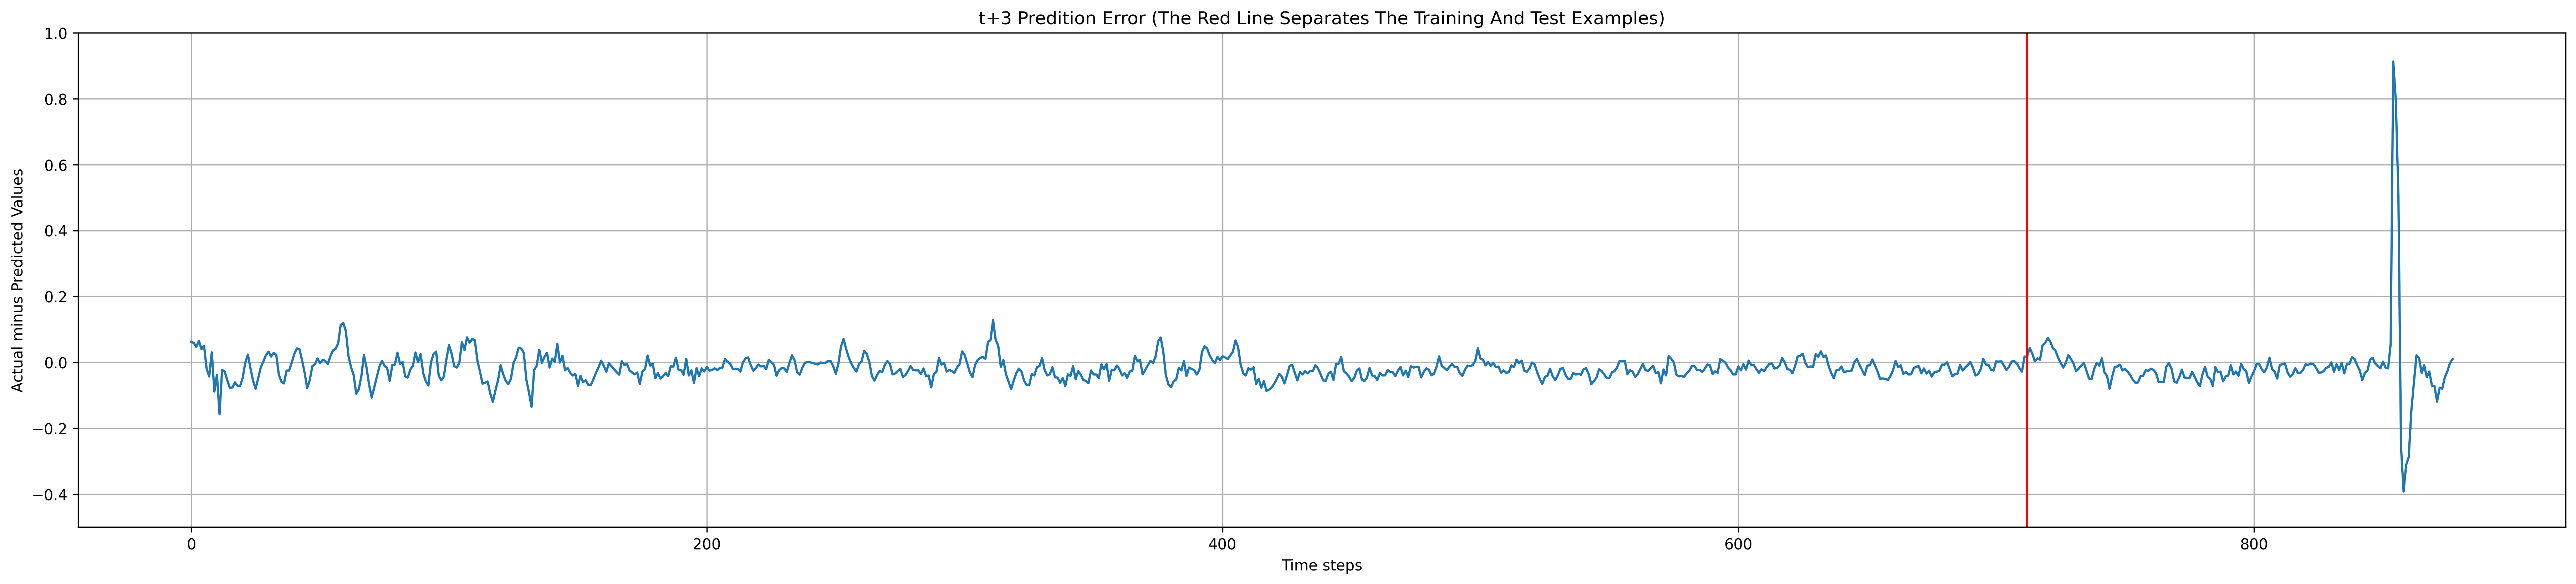

In [7]:
# Plot the prediction error
def plot_result2(trainY, testY, train_predict, test_predict,i):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(30, 6), dpi=300)
    plt.plot(range(rows), actual - predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.xlabel('Time steps')
    plt.ylabel('Actual minus Predicted Values')
    plt.title('t+%d Predition Error (The Red Line Separates The Training And Test Examples)' % (i+1))
    plt.ylim(-0.5, +1.0) # Please, set the interval appropriately, considering all the graphs.
    plt.grid(True)

for i in range(horizon):
  if(horizon == 1):
    y1_pred = train_predict
    y1_pred_t = test_predict
    y1 = y
    y1_t = yt
  elif(horizon > 1):
    y1_pred = train_predict[:,i]
    y1_pred_t = test_predict[:,i]
    y1 = y[:,i]
    y1_t = yt[:,i]
  plot_result2(y1, y1_t, y1_pred, y1_pred_t,i)

In [8]:
# Meaningful only for the simple RNN model (not for LP, MLP, ESN or LSTM)
wx = model.get_weights()[0]
wh = model.get_weights()[1]
bh = model.get_weights()[2]
wy = model.get_weights()[3]
by = model.get_weights()[4]
print(wx.shape)
print(wh.shape)
print(bh.shape)
print(wy.shape)
print(by.shape)

(1, 30)
(30, 30)
(30,)
(30, 3)
(3,)
